# Notebook to train the dataset on Microsoft Custom Vision

Just as last time, we do the following.
- 

In [225]:
import pandas as pd
import time
from tqdm import tqdm
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry
from msrest.authentication import ApiKeyCredentials
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
ENDPOINT = ""

In [218]:
training_key = ""
prediction_key = ""
prediction_resource_id = "/subscriptions/101c228b-7ec2-48c2-b9d3-f012863db5b7/resourceGroups/ai-resourcegroup/providers/Microsoft.CognitiveServices/accounts/fernando-custom-vision"

publish_iteration_name = "Iteration1"

credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)

# Get project
print ("Getting project...")
project = trainer.get_project('')
project

Getting project...


Get images from file system

In [7]:
df_labels = pd.read_csv("input/labels.csv")
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
df_labels['filename'] = df_labels.id.map(lambda id: f'input/data/train/{id}.jpg')
df_labels.head()

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,input/data/train/000bec180eb18c7604dcecc8fe0db...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,input/data/train/001513dfcb2ffafc82cccf4d8bbab...
2,001cdf01b096e06d78e9e5112d419397,pekinese,input/data/train/001cdf01b096e06d78e9e5112d419...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,input/data/train/00214f311d5d2247d5dfe4fe24b23...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,input/data/train/0021f9ceb3235effd7fcde7f7538e...


In [34]:
df_breeds = df_labels.breed.unique()
print(f'The amount of unique breeds in list: {len(df_breeds)}')

The amount of unique breeds in list: 120


array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

# Creating the tags in the project.

Seeing the distribution of the dataset, that leads to 120 unique breeds, so 120 tags will be created in this Custom Vision project.

In [43]:
existing_tags = []
for existing_tag in trainer.get_tags(project_id=project.id):
    existing_tags.append(existing_tag.name)

for tag in df_breeds:
    if (tag in existing_tags):
        print(f'Tag {tag} already exist in Custom Vision project')
    else:
        trainer.create_tag(project.id, tag)
        print(f'Just created tag: {tag}')

Tag boston_bull already exist in Custom Vision project
Tag dingo already exist in Custom Vision project
Tag pekinese already exist in Custom Vision project
Tag bluetick already exist in Custom Vision project
Tag golden_retriever already exist in Custom Vision project
Tag bedlington_terrier already exist in Custom Vision project
Just created tag: borzoi
Just created tag: basenji
Just created tag: scottish_deerhound
Just created tag: shetland_sheepdog
Just created tag: walker_hound
Just created tag: maltese_dog
Just created tag: norfolk_terrier
Just created tag: african_hunting_dog
Just created tag: wire-haired_fox_terrier
Just created tag: redbone
Just created tag: lakeland_terrier
Just created tag: boxer
Just created tag: doberman
Just created tag: otterhound
Just created tag: standard_schnauzer
Just created tag: irish_water_spaniel
Just created tag: black-and-tan_coonhound
Just created tag: cairn
Just created tag: affenpinscher
Just created tag: labrador_retriever
Just created tag: ib

# Create ImageFileEntry object from Image

For every image a ImageFileEntry object will be created and later been send to Custom Vision to insert the images.

In [93]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [104]:
print(f'{df_labels.filename.values[0]}')
print(f'{df_labels.id.values[0]}')
print(f'{df_labels.breed.values[0]}')

input/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg
000bec180eb18c7604dcecc8fe0dba07
boston_bull


## if you need to delete image batches from Custom Vision.
This code delete the length of the array of images.

In [111]:
for b in batch(df_labels.filename.values, 64):
    trainer.delete_images(project.id, image_ids=b)

In [121]:
for tag in trainer.get_tags(project.id):
    trainer.delete_tag(project.id, tag.id)

In [157]:
def get_existing_tag_id(check_tag_name):
    for tag in trainer.get_tags(project.id):
        if (check_tag_name == tag.name):
            return tag.id
    return None

This code uploads each image with its corresponding tag. You can upload up to 64 images in a single batch.

In [166]:
for b in batch(df_labels.values, 64):
    image_list = []
    # print(b)
    for i, row in enumerate(b):
        image_id, breed, filepath = row
        print(image_id, breed, filepath)
        if get_existing_tag_id(breed) == None:
            print('tag doesnt exist')
            new_tag = trainer.create_tag(project.id, breed)
            print('new tag', new_tag)
            with open(filepath, "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=image_id, contents=image_contents.read(), tag_ids=[new_tag.id]))
        else:
            print('tag exists')
            t_id = get_existing_tag_id(breed)
            with open(filepath, "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=image_id, contents=image_contents.read(), tag_ids=[t_id]))
                
    upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=image_list))
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)

fbd70c8820a6fbcd21242284baa8ba27 shetland_sheepdog input/data/train/fbd70c8820a6fbcd21242284baa8ba27.jpg
tag exists
fbd75ba5bf5ce7ef08a11a69c5ef263c vizsla input/data/train/fbd75ba5bf5ce7ef08a11a69c5ef263c.jpg
tag exists
fbdeba9ec017fc43c814e2688ad62402 sealyham_terrier input/data/train/fbdeba9ec017fc43c814e2688ad62402.jpg
tag exists
fbee719275e23f753f3cd1d9f83db21f miniature_pinscher input/data/train/fbee719275e23f753f3cd1d9f83db21f.jpg
tag exists
fbf3162c4df3f1a527cb0b26ef062704 australian_terrier input/data/train/fbf3162c4df3f1a527cb0b26ef062704.jpg
tag exists
fbf6ac0549525e721d3d3e48e27db4c5 west_highland_white_terrier input/data/train/fbf6ac0549525e721d3d3e48e27db4c5.jpg
tag exists
fbf881c1bd9b236af37efdfeb4a1fb51 rhodesian_ridgeback input/data/train/fbf881c1bd9b236af37efdfeb4a1fb51.jpg
tag exists
fbfb5da3096f8d12329dc9a02de83dd3 border_collie input/data/train/fbfb5da3096f8d12329dc9a02de83dd3.jpg
tag exists
fc0020cc00e3b1c7ec453ec129e17838 bull_mastiff input/data/train/fc0020cc00e

# Train for an iteration

With this peace of code, an iteration, also knowns also an training session will be created and started.

In [167]:
iteration = trainer.train_project(project_id=project.id)
while iteration.status != "Completed":
    iteration = trainer.get_iteration(project.id, iteration.id)
    print(f'Training status: {iteration.status}')
    time.sleep(1)

g status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training status: Completed
Training

KeyboardInterrupt: 

# The iteration is now trained.

Publish it to the project endpoint. So that we can use the Custom Service prediction endpoint. The name given to the published iteration can be used to send prediction requests. An iteration is not available in the prediction endpoint until it is published.

In [203]:
iteration = trainer.get_iteration(project.id, iteration_id='43faab13-c5c9-4af3-958c-f4c03cbf71b9')
print(iteration.original_publish_resource_id)
print(iteration)
# trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, iteration.original_publish_resource_id)

/subscriptions/101c228b-7ec2-48c2-b9d3-f012863db5b7/resourceGroups/ai-resourcegroup/providers/Microsoft.CognitiveServices/accounts/fernandocustomvisi-Prediction
{'additional_properties': {}, 'id': '43faab13-c5c9-4af3-958c-f4c03cbf71b9', 'name': 'Iteration 1', 'status': 'Completed', 'created': datetime.datetime(2020, 10, 21, 8, 6, 56, 860000, tzinfo=<isodate.tzinfo.Utc object at 0x1179327c0>), 'last_modified': datetime.datetime(2020, 10, 21, 18, 34, 7, 826000, tzinfo=<isodate.tzinfo.Utc object at 0x1179327c0>), 'trained_at': datetime.datetime(2020, 10, 21, 17, 54, 58, 242000, tzinfo=<isodate.tzinfo.Utc object at 0x1179327c0>), 'project_id': 'fe059deb-8195-4b94-8a44-61ae5d76fce5', 'exportable': True, 'exportable_to': ['VAIDK', 'CoreML', 'DockerFile', 'ONNX', 'OpenVino', 'TensorFlow'], 'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5', 'classification_type': 'Multiclass', 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 12, 'publish_name': 'Iteratio

# Use the prediction endpoint
To send an image to the prediction endpoint and retrieve the prediction, add the following code to the end of the file

In [178]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

In [222]:
prediction_credentials = ApiKeyCredentials(in_headers={'Prediction-Key': prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)
print(predictor)

t = []
p = []
with open('input/data/test/0a0b97441050bba8e733506de4655ea1.jpg', 'rb') as image_contents:
    results = predictor.classify_image(project.id, 'Iteration1', image_contents.read())

    for pred in results.predictions[:5]: # limit the result to top 5 predictions
        t.append(pred.tag_name)
        p.append(pred.probability)
        print("\t" + pred.tag_name +
              ": {0:.2f}%".format(pred.probability * 100))

	black-and-tan_coonhound: 57.70%
	rottweiler: 13.24%
	doberman: 10.54%
	gordon_setter: 8.15%
	bloodhound: 4.23%


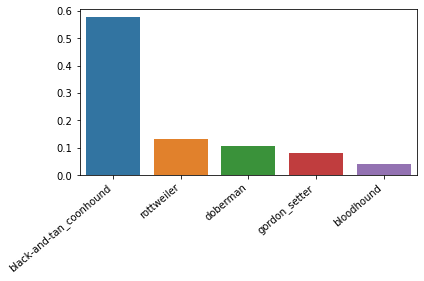

In [226]:
ax = sns.barplot(x=t, y=p)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()
plt.show()